# 04. Feature engineering

## Objectives

The goal of this notebook is to engineer meaningful features from the raw language skill scores to improve the model’s ability to predict CEFR levels, while preventing data leakage. Specifically, we aim to:

- Encode the categorical target variable (`overall_cefr`) into numerical labels for classification.  
- Create derived features that capture **relative skill patterns** (e.g., strongest/weakest skill, productive vs. receptive balance, variance across skills).  
- Identify learners’ **learning profiles** (balanced vs. uneven development) for more interpretable modelling.  
- Drop the raw scores after feature engineering to ensure the model learns from patterns rather than memorizing absolute exam results.  
- Prepare a feature matrix (`X`) and target vector (`y`) that are fair, generalizable, and ready for machine learning.  

## Inputs

- Cleaned dataset: `data/clean/cleaned_lang_proficiency_results.csv`  
- Columns: `speaking_score`, `reading_score`, `listening_score`, `writing_score`, `overall_cefr`  

## Outputs

- Encoded target labels for CEFR levels.  
- Engineered features capturing relative strengths, weaknesses, and learner profiles.  
- Removal of raw skill scores to mitigate leakage.  
- Train/test-ready dataset with only derived features and encoded labels.  

## Additional Information

Feature engineering bridges the gap between exploratory analysis and machine learning readiness.  
A key finding from the **EDA phase** was that raw scores are highly correlated with CEFR levels, posing a leakage risk.  
To address this, we focus on engineered features that represent **skill relationships and learner profiles** rather than raw performance.  
This ensures the final model is robust, interpretable, and aligned with the business requirement of **automatic learner placement and personalized recommendations**.  

---

# Project Directory Structure

## Change working directory

We need to change the working directory from its current folder to the folder the code of this project is currently located

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\husse\\OneDrive\\Projects\\lang-level-pred\\jupyter_notebooks'

In [2]:
from pathlib import Path

# swtich to project root directory
project_root = Path.cwd().parent
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\husse\OneDrive\Projects\lang-level-pred


---

# Data loading
This code block imports fundamental Python libraries for data analysis and visualization and checks their versions

- pandas: For data manipulation and analysis
- numpy: For numerical computations
- matplotlib: For creating visualizations and plots
- seaborn: creating attractive and informative statistical graphics from datasets

The version checks help ensure:
- Code compatibility across different environments
- Reproducibility of analysis
- Easy debugging of version-specific issues

In [64]:
# Import data analysis tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

pandas version: 2.3.1
NumPy version: 2.3.1
matplotlib version: 3.10.5
seaborn version: 0.13.2


### List Files and Folders
- This code shows what files and folders are in our data/clean folder and what folder we are currently in. 

In [3]:
import os
from pathlib import Path

dataset_dir = Path("data/clean")
print(f"[INFO] Files/folders available in {dataset_dir}:")
os.listdir(dataset_dir)

[INFO] Files/folders available in data\clean:


['cleaned_lang_proficiency_results.csv']

## Load dataset
This code loads the dataset from the data/clean folder that is then displayed in the dataframe.

In [154]:
import pandas as pd
from pathlib import Path

# Define the path to the CSV file
file_path = Path("data/clean/cleaned_lang_proficiency_results.csv")

# Read the CSV file
df = pd.read_csv(file_path)
df.head()

,speaking_score,reading_score,listening_score,writing_score,overall_cefr
0,24,38,30,34,A1
1,93,91,90,89,C1
2,62,64,64,55,B1
3,63,59,54,54,B1
4,79,74,85,79,B2


---

## 1. Target Variable Encoding

The target variable `overall_cefr` is categorical (A1–C2).  
To use it in machine learning classification models, we need to encode it into numeric labels.  

We will apply the following mapping:

- A1 → 0  
- A2 → 1  
- B1 → 2  
- B2 → 3  
- C1 → 4  
- C2 → 5  

This preserves the natural order of proficiency levels while making the target compatible with scikit-learn classifiers.

In [155]:
# Define mapping for CEFR levels
cefr_mapping = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}

# Apply mapping to target column
df["cefr_encoded"] = df["overall_cefr"].map(cefr_mapping)

df.info()

# Verify encoding
print("✅ Target variable encoded successfully!")
print(df[["overall_cefr", "cefr_encoded"]].head(10))

# Check value counts to confirm distribution
print("\nEncoded CEFR distribution:")
print(df["cefr_encoded"].value_counts().sort_index())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   speaking_score   1004 non-null   int64 
 1   reading_score    1004 non-null   int64 
 2   listening_score  1004 non-null   int64 
 3   writing_score    1004 non-null   int64 
 4   overall_cefr     1004 non-null   object
 5   cefr_encoded     1004 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 47.2+ KB
✅ Target variable encoded successfully!
  overall_cefr  cefr_encoded
0           A1             0
1           C1             4
2           B1             2
3           B1             2
4           B2             3
5           B1             2
6           A2             1
7           B2             3
8           A2             1
9           B1             2

Encoded CEFR distribution:
cefr_encoded
0    208
1    219
2    208
3    192
4     94
5     83
Name: count, dtype: int64


## 2. Feature Engineering

In this step, we create additional features from the four base skill scores (*speaking, reading, listening, writing*).  
These engineered features provide richer insights into learner profiles and enhance the model’s ability to predict CEFR levels.

The following **7 engineered features** are created:

1. **strongest_skill** → learner’s best-performing skill.  
2. **weakest_skill** → learner’s lowest-performing skill (main bottleneck).  
3. **second_weakest_skill** → captures the learner’s secondary weakness for targeted recommendations.  
4. **strength_weakness_gap** → difference between strongest and weakest skill scores.  
5. **learning_profile** → categorical label:  
   - *Balanced* → skills are evenly developed (low variance).  
   - *Uneven Development* → large discrepancies between strengths and weaknesses.  
6. **speaking_minus_avg** → difference between speaking score and learner’s average.  
7. **reading_minus_avg** → difference between reading score and learner’s average.  
8. **listening_minus_avg** → difference between listening score and learner’s average.  
9. **writing_minus_avg** → difference between writing score and learner’s average.  
10. **productive_dominant** → binary flag:  
    - `1` → Productive (speaking + writing) stronger.  
    - `0` → Receptive (reading + listening) stronger.  
11. **speaking_level** → categorical bucket (*Beginner / Intermediate / Advanced*).  
12. **reading_level** → categorical bucket (*Beginner / Intermediate / Advanced*).  
13. **listening_level** → categorical bucket (*Beginner / Intermediate / Advanced*).  
14. **writing_level** → categorical bucket (*Beginner / Intermediate / Advanced*).  

**Important: Preventing Data Leakage**  
The raw scores (*speaking_score, reading_score, listening_score, writing_score*) are highly correlated with CEFR and would cause the model to “cheat” by memorizing direct score-to-level mappings.  
To ensure fairness and generalization, we **drop the raw scores after feature engineering**, keeping only the derived features listed above.  

This ensures the model learns from **relative skill patterns and learner profiles**, not from absolute exam results.


In [ ]:
import numpy as np
import pandas as pd

# List of core skill columns
skill_cols = ["speaking_score", "reading_score", "listening_score", "writing_score"]

# Strongest and weakest skills
df["strongest_skill"] = df[skill_cols].idxmax(axis=1).str.replace("_score", "")
df["weakest_skill"] = df[skill_cols].idxmin(axis=1).str.replace("_score", "")

# Second weakest skill
df["second_weakest_skill"] = df[skill_cols].apply(
    lambda row: row.sort_values().index[1].replace("_score", ""), axis=1
)

# Gap between strongest and weakest
df["strength_weakness_gap"] = df[skill_cols].max(axis=1) - df[skill_cols].min(axis=1)


# Learning profile classification
gap_threshold = df["strength_weakness_gap"].quantile(0.75)
print(f"Gap threshold for Uneven Development: {gap_threshold:.2f}")

df["learning_profile"] = np.where(
    df["strength_weakness_gap"] > gap_threshold,
    "Uneven Development",
    "Balanced"
)

# Relative strength of each skill compared to learner’s average
df["speaking_minus_avg"] = df["speaking_score"] - df[skill_cols].mean(axis=1)
df["reading_minus_avg"] = df["reading_score"] - df[skill_cols].mean(axis=1)
df["listening_minus_avg"] = df["listening_score"] - df[skill_cols].mean(axis=1)
df["writing_minus_avg"] = df["writing_score"] - df[skill_cols].mean(axis=1)


# Productive vs Receptive dominance (binary flag)
df["productive_dominant"] = np.where(
    (df["speaking_score"] + df["writing_score"]) >
    (df["reading_score"] + df["listening_score"]),
    1,  # Productive dominant
    0   # Receptive dominant
)

# --- NEW FEATURE: Categorical buckets (Beginner / Intermediate / Advanced) ---
def bucketize(score):
    if score < 33:
        return "Beginner"
    elif score < 66:
        return "Intermediate"
    else:
        return "Advanced"

for skill in skill_cols:
    df[f"{skill.replace('_score','')}_level"] = df[skill].apply(bucketize)

# ✅ Drop raw scores AFTER all feature engineering
df = df.drop(columns=skill_cols)

# Preview final engineered dataset
df.head()

Gap threshold for Uneven Development: 11.00


,overall_cefr,cefr_encoded,strongest_skill,weakest_skill,second_weakest_skill,strength_weakness_gap,learning_profile,speaking_minus_avg,reading_minus_avg,listening_minus_avg,writing_minus_avg,productive_dominant,speaking_level,reading_level,listening_level,writing_level
0,A1,0,reading,speaking,listening,14,Uneven Development,-7.50,6.50,-1.50,2.50,0,Beginner,Intermediate,Beginner,Intermediate
1,C1,4,speaking,writing,listening,4,Balanced,2.25,0.25,-0.75,-1.75,1,Advanced,Advanced,Advanced,Advanced
2,B1,2,reading,writing,speaking,9,Balanced,0.75,2.75,2.75,-6.25,0,Intermediate,Intermediate,Intermediate,Intermediate
3,B1,2,speaking,listening,listening,9,Balanced,5.50,1.50,-3.50,-3.50,1,Intermediate,Intermediate,Intermediate,Intermediate
4,B2,3,listening,reading,speaking,11,Balanced,-0.25,-5.25,5.75,-0.25,0,Advanced,Advanced,Advanced,Advanced


## 3. Feature Visualization

- **Correlation Heatmap** – shows relationships between numeric engineered features, helping to spot redundancy.  
- **Boxplots** – compare distributions of each numeric feature across CEFR levels to see which separate learners best.  
- **Feature–Target Correlation** – measures how strongly each numeric feature relates to encoded CEFR, highlighting the most predictive ones. 


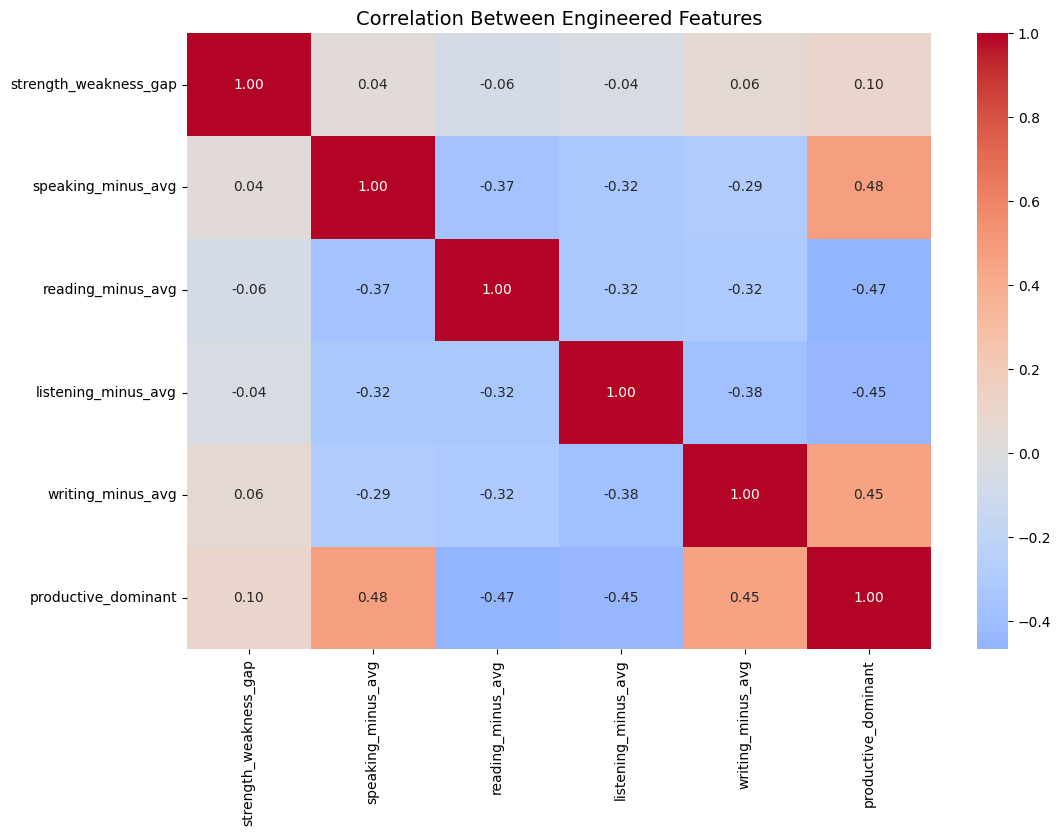

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")


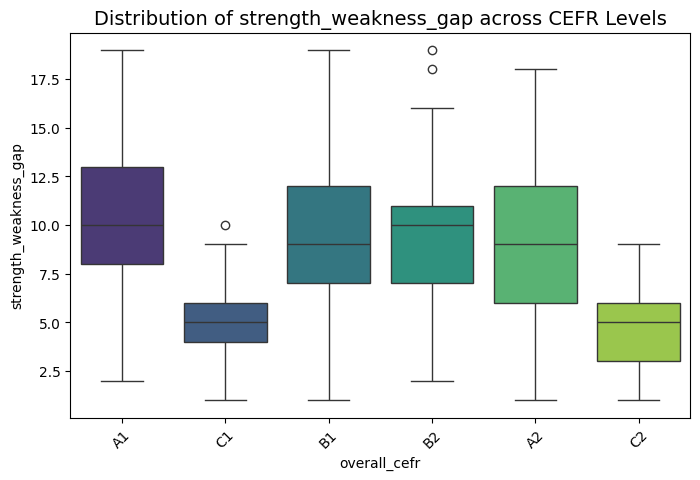

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")


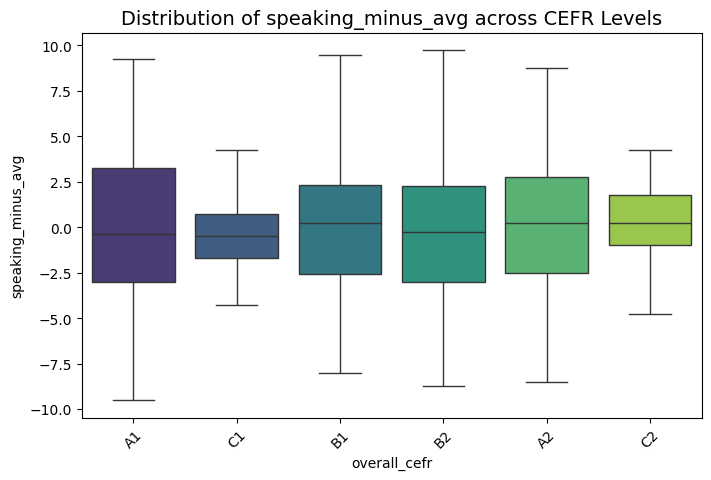

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")


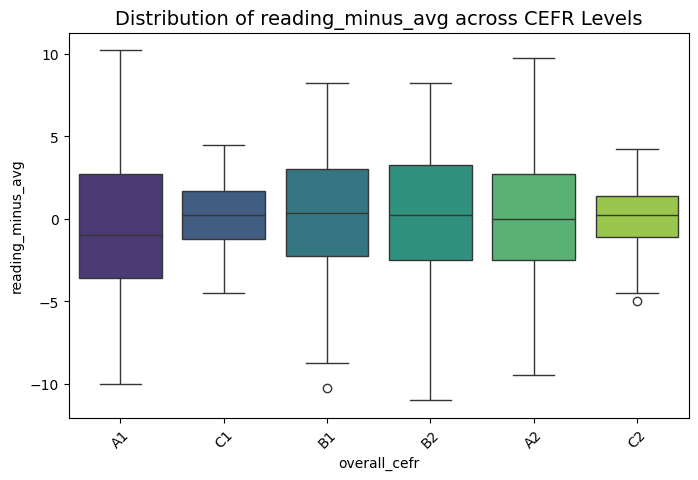

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")


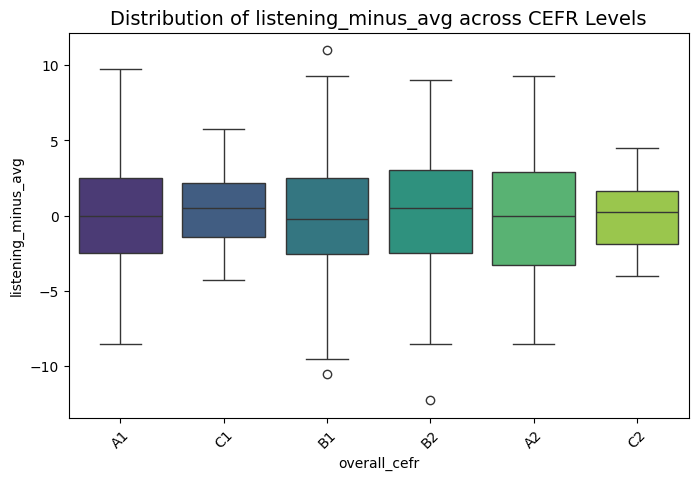

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")


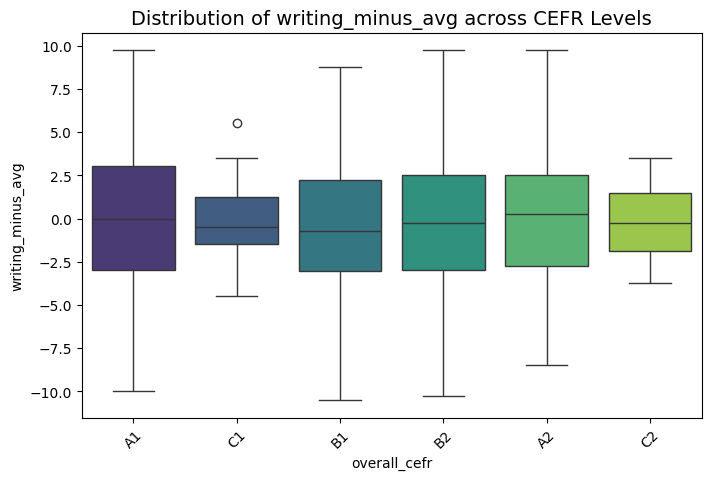

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")


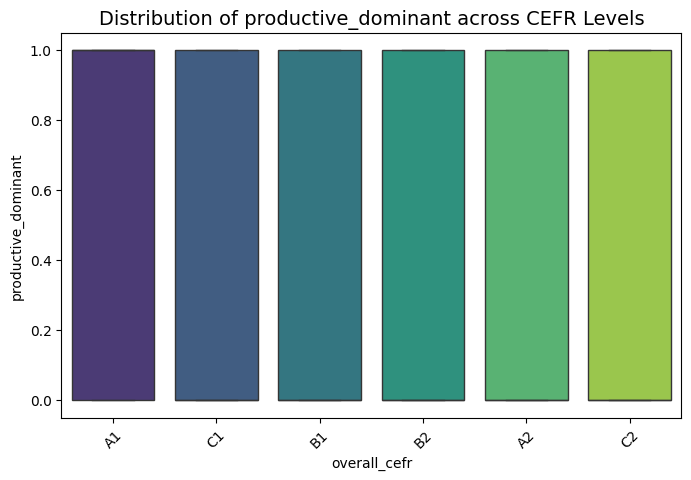

C:\Users\husse\AppData\Local\Temp\ipykernel_67356\658319859.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="magma")


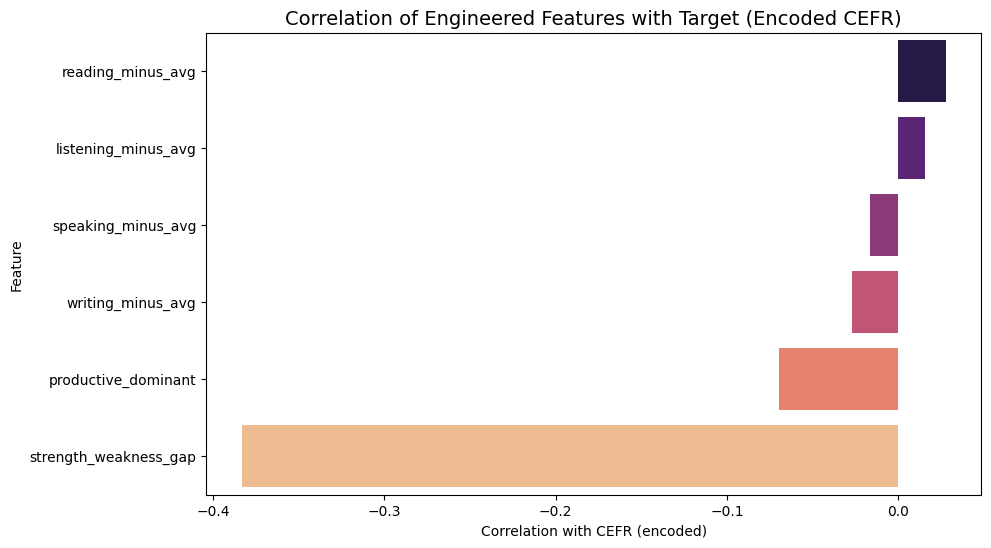

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Separate numeric engineered features (skip categorical like strongest_skill)
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=["cefr_encoded"], errors="ignore")

# 1️⃣ Correlation Heatmap (between engineered features only)
plt.figure(figsize=(12, 8))
corr = numeric_features.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Between Engineered Features", fontsize=14)
plt.show()

# 2️⃣ Boxplots: How each engineered feature varies across CEFR levels
for col in numeric_features.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="overall_cefr", y=col, data=df, palette="viridis")
    plt.title(f"Distribution of {col} across CEFR Levels", fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# 3️⃣ Feature vs Target Correlation (numeric only, with encoded CEFR if available)
if "cefr_encoded" in df.columns:
    target_corr = numeric_features.corrwith(df["cefr_encoded"]).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette="magma")
    plt.title("Correlation of Engineered Features with Target (Encoded CEFR)", fontsize=14)
    plt.xlabel("Correlation with CEFR (encoded)")
    plt.ylabel("Feature")
    plt.show()

## Insights

### Correlation Heatmap  
- Most engineered features show moderate correlations, meaning they capture distinct aspects of learner performance.  
- `productive_dominant` aligns positively with productive skills and negatively with receptive ones, confirming its intended design.  
- `strength_weakness_gap` is weakly correlated with other features, suggesting it provides unique information on variability.  

### Skill Gap (`strength_weakness_gap`) across CEFR Levels  
- Lower-level learners (A1–B1) tend to show wider skill gaps, indicating uneven development.  
- Higher-level learners (C1–C2) typically have smaller gaps, reflecting more balanced proficiency.  

### Productive Dominance (`productive_dominant`) across CEFR Levels  
- Distributions are balanced across CEFR levels, with no group dominated by one learning mode.  
- Dominance type is not tied to level but remains useful for tailoring recommendations (e.g., boosting weaker modalities).  

## 4. Scaling / Normalization

Machine learning models are sensitive to the scale of input features, especially distance-based methods (e.g., KNN, SVM) and gradient-based optimizers (e.g., Logistic Regression, Neural Networks).  
Since the skill scores (0–100) and engineered features (e.g., ratios, gaps) exist on different scales, we standardize all numeric features to have:

- Mean = 0  
- Standard Deviation = 1  

This ensures that each feature contributes fairly to the model and avoids bias toward high-magnitude features.  
We use **StandardScaler** from scikit-learn for normalization.

In [158]:
# --- Step 6: Scaling / Normalization ---
from sklearn.preprocessing import StandardScaler

# Select feature columns (exclude target)
feature_cols = [
    "strength_weakness_gap",
    "speaking_minus_avg", "reading_minus_avg", "listening_minus_avg", "writing_minus_avg",
    "productive_dominant"
]

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
X_scaled = scaler.fit_transform(df[feature_cols])

# Convert back to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# ✅ Replace original columns with scaled ones
df[feature_cols] = X_scaled_df

# Preview scaled features
X_scaled_df.head()

,strength_weakness_gap,speaking_minus_avg,reading_minus_avg,listening_minus_avg,writing_minus_avg,productive_dominant
0,1.427690,-2.069500,1.751171,-0.421848,0.720782,-0.895831
1,-1.225282,0.609820,0.058795,-0.221437,-0.438501,1.116282
2,0.101204,0.197617,0.735745,0.713814,-1.665976,-0.895831
3,0.101204,1.502926,0.397270,-0.956277,-0.915852,1.116282
4,0.631798,-0.077185,-1.430496,1.515458,-0.029342,-0.895831


## 5. Train/Test Split (with Categorical Encoding)

In this step, we prepare the dataset for model training by ensuring the data is correctly split and all features are numerical.  

**Process:**  
1. **Split the dataset** into training and testing sets using stratified sampling to preserve the distribution of CEFR levels.  
2. **Identify categorical engineered features**:  
   - `strongest_skill`  
   - `weakest_skill`  
   - `second_weakest_skill`  
   - `learning_profile`  
   - `speaking_level`  
   - `reading_level`  
   - `listening_level`  
   - `writing_level`  
3. **Encode categorical features** using **One-Hot Encoding (OHE)** to convert them into numerical dummy variables.  
4. **Retain numeric features** (already engineered in Step 2) without further modification.  
5. Combine the numeric and encoded categorical features to form the final training and test sets (`X_train_final`, `X_test_final`).  

This ensures the dataset is fully numeric, consistent, and ready for use in the **Modeling & Evaluation** step.  

In [159]:
# Train/Test Split with Categorical Encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Define target
y = df["cefr_encoded"]

# Features (drop raw CEFR columns)
X = df.drop(columns=["overall_cefr", "cefr_encoded"])

# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape (before encoding):", X_train.shape)
print("Test set shape (before encoding):", X_test.shape)

# ---- Handle Categorical Features ---- #
categorical_features = ["strongest_skill", "weakest_skill", "second_weakest_skill", "learning_profile", "reading_level", "listening_level", "speaking_level", "writing_level"]

# Initialize OneHotEncoder
ohe = OneHotEncoder(drop="first", sparse_output=False)  # drop="first" avoids dummy trap

# Fit on training set only (to avoid data leakage)
X_train_cat = ohe.fit_transform(X_train[categorical_features])
X_test_cat = ohe.transform(X_test[categorical_features])

# Get feature names after encoding
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Convert to DataFrame
import pandas as pd
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe_feature_names, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe_feature_names, index=X_test.index)

# Drop original categorical columns and join encoded ones
X_train_final = pd.concat([X_train.drop(columns=categorical_features), X_train_cat], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_features), X_test_cat], axis=1)

print("Training set shape (after encoding):", X_train_final.shape)
print("Test set shape (after encoding):", X_test_final.shape)

# Quick check on final dataset
X_train_final.head()

Training set shape (before encoding): (803, 14)
Test set shape (before encoding): (201, 14)
Training set shape (after encoding): (803, 24)
Test set shape (after encoding): (201, 24)


,strength_weakness_gap,speaking_minus_avg,reading_minus_avg,listening_minus_avg,writing_minus_avg,productive_dominant,strongest_skill_reading,strongest_skill_speaking,strongest_skill_writing,weakest_skill_reading,...,second_weakest_skill_writing,learning_profile_Uneven Development,reading_level_Beginner,reading_level_Intermediate,listening_level_Beginner,listening_level_Intermediate,speaking_level_Beginner,speaking_level_Intermediate,writing_level_Beginner,writing_level_Intermediate
575,1.692987,0.266317,2.428122,-1.089884,-1.597783,-0.895831,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
576,1.162393,-1.794698,0.397270,-0.421848,1.811872,-0.895831,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
914,-0.429390,1.022023,-0.618156,0.446600,-0.847659,1.116282,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.631798,0.609820,0.058795,1.114636,-1.802363,-0.895831,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632,-0.164093,-0.420688,1.480391,-0.689062,-0.370308,-0.895831,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## 5. Final Feature Set Overview  

In this step, we will validate the final dataset before moving to the **Modelling & Evaluation** stage. Specifically, we will:  

- Inspect the final **feature matrix (`X`)** and **target (`y`)**.  
- Confirm the **dimensions** of the train/test splits after preprocessing.  
- Preview the **transformed features** to check that both numerical (scaled) and categorical (one-hot encoded) variables are included.  
- Verify that **stratified sampling** preserved the distribution of CEFR levels in both training and testing sets.

This step ensures that the dataset is properly structured and balanced, which is essential for reliable model training and evaluation.  

In [160]:
# Check shapes of train/test splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Preview feature matrix (first 5 rows)
print("\nSample of transformed features (X_train):")
print(X_train[:5])


unique, counts = np.unique(y_train, return_counts=True)
train_dist = dict(zip(unique, counts))
unique, counts = np.unique(y_test, return_counts=True)
test_dist = dict(zip(unique, counts))

print("\nTarget distribution (train):", train_dist)
print("Target distribution (test):", test_dist)


X_train shape: (803, 14)
X_test shape: (201, 14)
y_train shape: (803,)
y_test shape: (201,)

Sample of transformed features (X_train):
    strongest_skill weakest_skill second_weakest_skill  strength_weakness_gap  \
575         reading       writing            listening               1.692987   
576         writing      speaking            listening               1.162393   
914        speaking       writing              reading              -0.429390   
665       listening       writing              reading               0.631798   
632         reading     listening             speaking              -0.164093   

       learning_profile  speaking_minus_avg  reading_minus_avg  \
575  Uneven Development            0.266317           2.428122   
576  Uneven Development           -1.794698           0.397270   
914            Balanced            1.022023          -0.618156   
665            Balanced            0.609820           0.058795   
632            Balanced           -0.420688     

## 6. Save Processed Data  

In this step, we will save the **final preprocessed dataset** so that it can be reused in the **Modelling & Evaluation notebook** without repeating all preprocessing steps.  

We will:  
- Save the **feature matrix (`X`)** and **target (`y`)** into CSV files.  
- Store them inside the `data/processed/` folder for good project structure.  
- Confirm that the files were saved successfully by reloading and inspecting their shapes.  

This ensures reproducibility and keeps a clear separation between **raw**, **intermediate**, and **processed** data.  

In [161]:
import os

# Create processed data folder if it doesn't exist
os.makedirs("data/processed", exist_ok=True)

# Save processed features and target
X.to_csv("data/processed/features.csv", index=False)
y.to_csv("data/processed/target.csv", index=False)

print("✅ Processed data saved successfully!")

# Quick validation
print("Features shape:", X.shape)
print("Target shape:", y.shape)

✅ Processed data saved successfully!
Features shape: (1004, 14)
Target shape: (1004,)


---

# Conclusion

## 7. Summary & Next Steps  

In this notebook, we:  

- Imported and verified the **cleaned dataset**.  
- Encoded the **target variable (CEFR levels)** into numerical labels.  
- Engineered **8 new features** to capture learner skill profiles (e.g., strongest/weakest skill, learning profile, productive_dominant etc.).  
- Scaled numeric features to ensure consistent ranges.  
- Encoded categorical engineered features using **One-Hot Encoding (OHE)**.  
- Performed a **stratified train/test split** to preserve CEFR class balance.  
- Saved the **processed dataset** for future use.  

At this point, we have a **ready-to-use dataset** with features (`X`) and target (`y`) prepared for Machine Learning.  

### Next Steps (Modelling & Evaluation Notebook)
In the next notebook, we will:  
- Load the processed features and target.  
- Build and train ML models (classification).  
- Evaluate model performance (classification report, confusion matrix, etc.).  
- Interpret results in terms of the **business requirements**.  
- Prepare the foundation for generating **personalised learning recommendations**.  